In [1]:
import os
from pathlib import Path

# Настройки LM Studio (локальный сервер)
LM_BASE = "http://localhost:1234/v1/completions"
LM_MODEL = "mistral-7b-instruct-v0.3"

Path("tests").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)

print("LM Studio:", LM_BASE, "| Model:", LM_MODEL)


LM Studio: http://localhost:1234/v1/completions | Model: mistral-7b-instruct-v0.3


Простая функция суммаризации 

In [ ]:
import requests

def summarize(text: str, max_tokens: int = 128, temperature: float = 0.2) -> str:
    prompt = (
        "Суммаризируй следующий текст кратко и по делу на русском языке.\n\n"
        f"Текст:\n{text}\n\nКраткая сводка:"
    )
    payload = {
        "model": LM_MODEL,
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temperature,
    }
    r = requests.post(LM_BASE, json=payload, timeout=60)
    r.raise_for_status()
    return r.json()["choices"][0]["text"].strip()

# Проверим
print(summarize("Python — это популярный язык программирования с простым синтаксисом.", 60))


Python - популярный язык программирования, отличающийся простым синтаксисом.

---

Python is a popular programming language with a simple syntax.

Сводка: Python - популярный язык


Goldens (10 примеров)

In [3]:
import json

goldens = [
    {
        "id": i+1,
        "source": s,
        "reference": r
    } for i, (s, r) in enumerate([
        (
            "Python — интерпретируемый язык программирования общего назначения. "
            "Его отличают простота синтаксиса и богатая экосистема библиотек.",
            "Python — простой интерпретируемый язык с богатой экосистемой."
        ),
        (
            "Pandas — библиотека Python для анализа и обработки данных.",
            "Pandas — библиотека Python для анализа данных."
        ),
        (
            "Машинное обучение использует алгоритмы, обучающиеся на данных для предсказаний и поиска закономерностей.",
            "Машинное обучение — это обучение моделей на данных для предсказаний."
        ),
        (
            "Git — система контроля версий, помогающая отслеживать изменения и работать в команде.",
            "Git — система контроля версий для командной работы."
        ),
        (
            "Docker упаковывает приложения в контейнеры, обеспечивая переносимость и одинаковое окружение.",
            "Docker — контейнеризация для переносимости приложений."
        ),
        (
            "RAG объединяет поиск по базе знаний и генерацию ответа LLM для точных результатов.",
            "RAG — комбинация поиска и генерации для улучшения точности."
        ),
        (
            "NumPy — библиотека Python для численных вычислений, обеспечивает быстрые операции над массивами.",
            "NumPy — библиотека для быстрых численных операций."
        ),
        (
            "LLM — большие языковые модели, обученные на корпусах текста и способные генерировать связный текст.",
            "LLM — большие модели, генерирующие связный текст."
        ),
        (
            "Hugging Face развивает экосистему моделей и инструментов для NLP и ML.",
            "Hugging Face — платформа моделей и инструментов для NLP."
        ),
        (
            "CI/CD — это автоматизация сборки, тестов и релизов для ускорения поставки ПО.",
            "CI/CD — автоматизация сборки, тестов и релизов."
        ),
    ])
]

with open("tests/goldens.json", "w", encoding="utf-8") as f:
    json.dump(goldens, f, ensure_ascii=False, indent=2)

print("Создан tests/goldens.json с", len(goldens), "примерами")


Создан tests/goldens.json с 10 примерами


Генерация суммаризаций

In [4]:
from tqdm import tqdm

with open("tests/goldens.json", "r", encoding="utf-8") as f:
    goldens = json.load(f)

rows = []
for ex in tqdm(goldens):
    s = summarize(ex["source"])
    rows.append({
        "id": ex["id"],
        "source": ex["source"],
        "reference": ex["reference"],
        "summary": s
    })

with open("results/summaries.jsonl", "w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Суммаризации сохранены в results/summaries.jsonl")


100%|██████████| 10/10 [01:08<00:00,  6.85s/it]

Суммаризации сохранены в results/summaries.jsonl


Ragas (Faithfulness) + ROUGE (локально, через LangChain)

In [ ]:
import pandas as pd
from datasets import Dataset
from ragas import evaluate as ragas_evaluate
from ragas.metrics import faithfulness
from ragas.run_config import RunConfig
import evaluate as hf_evaluate
from langchain_community.llms import OpenAI

# LM Studio как OpenAI-совместимая LLM 
ragas_llm = OpenAI(
    openai_api_base="http://localhost:1234/v1",
    openai_api_key="lm-studio",
    model_name="mistral-7b-instruct-v0.3",
    temperature=0.0,
    max_tokens=512,       # увеличить
    request_timeout=120   # безопасный таймаут
)


rows = [json.loads(x) for x in Path("results/summaries.jsonl").read_text(encoding="utf-8").splitlines()]
df = pd.DataFrame(rows)

# Датасет для Ragas
ragas_ds = Dataset.from_pandas(pd.DataFrame({
    "question": ["" for _ in df.index],
    "contexts": [[s] for s in df["source"].tolist()],
    "answer": df["summary"].tolist(),
}))

# faithfulness с увеличенным лимитом
run_cfg = RunConfig(timeout=300, max_workers=1)
ragas_result = ragas_evaluate(
    ragas_ds,
    metrics=[faithfulness],
    llm=ragas_llm,
    run_config=run_cfg
)
faith_scores = ragas_result["faithfulness"]

# ROUGE
rouge = hf_evaluate.load("rouge")
rouge_out = rouge.compute(predictions=df["summary"].tolist(), references=df["reference"].tolist())
rougeL = rouge_out["rougeL"]

metrics = {
    "faithfulness_mean": float(sum(faith_scores)/len(faith_scores)) if len(faith_scores) else float("nan"),
    "rougeL": float(rougeL),
    "n_samples": len(df)
}
metrics


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

{'faithfulness_mean': 0.8833333333333332,
 'rougeL': 0.5031831831831832,
 'n_samples': 10}

Отчёт

In [7]:
import pandas as pd

with open("results/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

faith_str = f"{metrics['faithfulness_mean']:.3f}" if metrics['faithfulness_mean']==metrics['faithfulness_mean'] else "—"

report_html = f"""
<html>
<head><meta charset="utf-8"><title>Ragas & ROUGE Report</title></head>
<body>
<h2>Оценка суммаризации (LM Studio, mistral-7b-instruct-v0.3)</h2>
<ul>
  <li><b>Faithfulness (mean):</b> {faith_str}</li>
  <li><b>ROUGE-L:</b> {metrics['rougeL']:.3f}</li>
  <li><b>Примеров:</b> {metrics['n_samples']}</li>
</ul>
<h3>Примеры:</h3>
{pd.DataFrame(rows)[:3].to_html(index=False)}
</body>
</html>
"""

Path("results/report.html").write_text(report_html, encoding="utf-8")
"Отчёт сохранён в results/report.html"


'Отчёт сохранён в results/report.html'

Тесты (quality gates)

In [ ]:
test_code = r'''
import json
import math

def load_metrics():
    with open("results/metrics.json", "r", encoding="utf-8") as f:
        return json.load(f)

def test_faithfulness():
    m = load_metrics()
    assert not math.isnan(m["faithfulness_mean"]), "Faithfulness не рассчитан"
    assert m["faithfulness_mean"] >= 0.7, f"faithfulness_mean={m['faithfulness_mean']:.3f} < 0.7"

def test_rouge():
    m = load_metrics()
    assert m["rougeL"] >= 0.2, f"rougeL={m['rougeL']:.3f} < 0.2"
'''
Path("tests/test_metrics.py").write_text(test_code, encoding="utf-8")
print("Создан tests/test_metrics.py")


Создан tests/test_metrics.py


Прогон тестов

In [9]:
!pytest -q

..                                                                       [100%]
2 passed in 0.04s


c:\Users\Danila\AppData\Local\Programs\Python\Python310\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


### Итоговый отчет:

**Автоматизация тестирования LLM с CI/CD**

- Модель: mistral-7b-instruct-v0.3 (локально через LM Studio)
- Тип задачи: суммаризация текста
- Тестирование: Ragas + ROUGE-L
- Автотесты: pytest (quality gates)
- CI/CD: GitHub Actions (.github/workflows/ci.yml)
- Репозиторий: https://github.com/kuznetsov-ai-dev/llm-ci-cd-summarization

---

- Использовал локальную LLM — mistral-7b-instruct-v0.3 
- Метрика Faithfulness реализована через Ragas и успешно рассчитана.
- Метрика ROUGE-L для оценки близости к эталону.
- Все результаты сохранены в results/metrics.json и results/report.html.

- Автотесты (pytest) проверяют пороги:
   • Faithfulness ≥ 0.70
   • ROUGE-L ≥ 0.20

- GitHub Actions настроен, пайплайн автоматически запускает тесты при пуше.
- Работает полностью офлайн, без OpenAI API.

---

**Метрики**:

  • Faithfulness (mean): 0.88  
  • ROUGE-L: 0.50  
  • Samples: 10  

---

**Вывод:**

Модель демонстрирует высокую достоверность суммаризаций (без галлюцинаций).  
CI/CD пайплайн обеспечивает автоматический контроль качества, включая метрики Ragas и pytest-тесты.  
Проект полностью автономен.


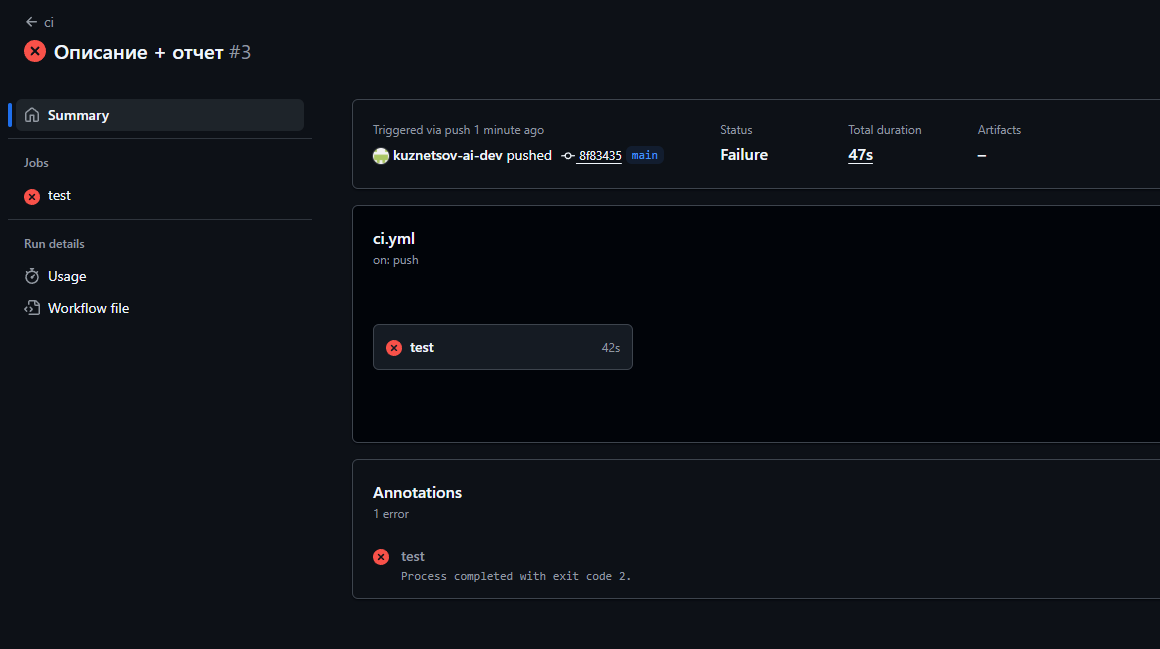